<a href="https://colab.research.google.com/github/koushika894/credit-card-fraud-detection/blob/main/kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection using Machine Learning

## Project Overview
Detect fraudulent credit card transactions using the Kaggle dataset. The data is highly imbalanced (fraud ≈ 0.17%), so evaluation focuses on recall and precision rather than accuracy alone.

## Objectives
- Perform concise EDA and verify data quality
- Address class imbalance with SMOTE
- Train and compare Logistic Regression vs Random Forest
- Tune hyperparameters and evaluate with recall-focused metrics

## Methods Used
- Data preprocessing and scaling
- SMOTE for class imbalance
- RandomizedSearchCV for tuning
- Cross-validation and confusion matrix analysis

## Executive Summary

- **Goal**: Detect fraudulent transactions in a highly imbalanced dataset (fraud ≈ 0.17%).
- **Approach**: EDA → preprocessing → baseline models → SMOTE balancing → hyperparameter tuning.
- **Models**: Logistic Regression and Random Forest.
- **Evaluation Focus**: Recall, Precision, F1, ROC‑AUC (accuracy is not sufficient for imbalanced data).
- **Outcome**: SMOTE + tuned Random Forest delivers the best balance of recall and precision.

In [ ]:
!pip install -q kaggle


## 1. Setup and Data Loading

### 1.1 Install Kaggle API

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"battakoushika","key":"224404efd8c13fce00bdd35c0ba1d0a0"}'}

### 1.2 Configure Kaggle API Credentials

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 943MB/s]


In [ ]:
!unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


### 1.3 Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold

## 2. Exploratory Data Analysis (EDA)

### 2.1 Load and Inspect Dataset

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

None

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


,count
Class,
0,284315
1,492


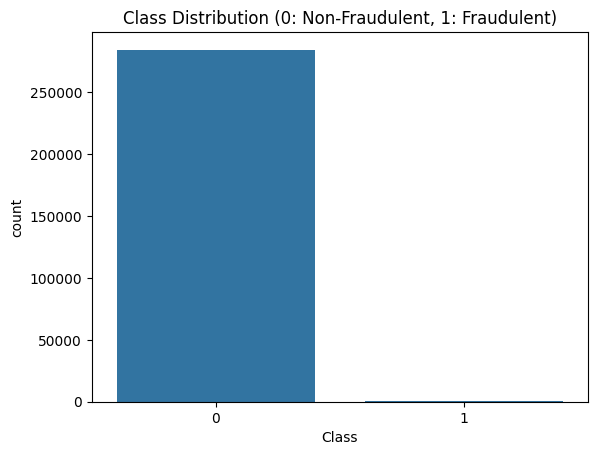

In [ ]:
# Load the dataset
df = pd.read_csv('creditcard.csv')

# Display the first few rows to check the data
display(df.head())

# Get information about the dataset (datatypes, non-null values)
display(df.info())

# Summary statistics
display(df.describe())

# Check for missing values
display(df.isnull().sum())

# Check the distribution of the target variable ('Class')
display(df['Class'].value_counts())

# Visualize the distribution of the target variable
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Non-Fraudulent, 1: Fraudulent)')
plt.show()

**Key Observations:**
- The dataset shows severe class imbalance (fraudulent transactions are rare)
- Features V1-V28 are PCA-transformed for privacy
- Time and Amount are the only non-transformed features

## 3. Data Preprocessing

### 3.1 Train-Test Split with Stratification

In [ ]:
# Separate features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (227845, 30)
Shape of X_test: (56962, 30)
Shape of y_train: (227845,)
Shape of y_test: (56962,)


### 3.2 Feature Correlation Analysis

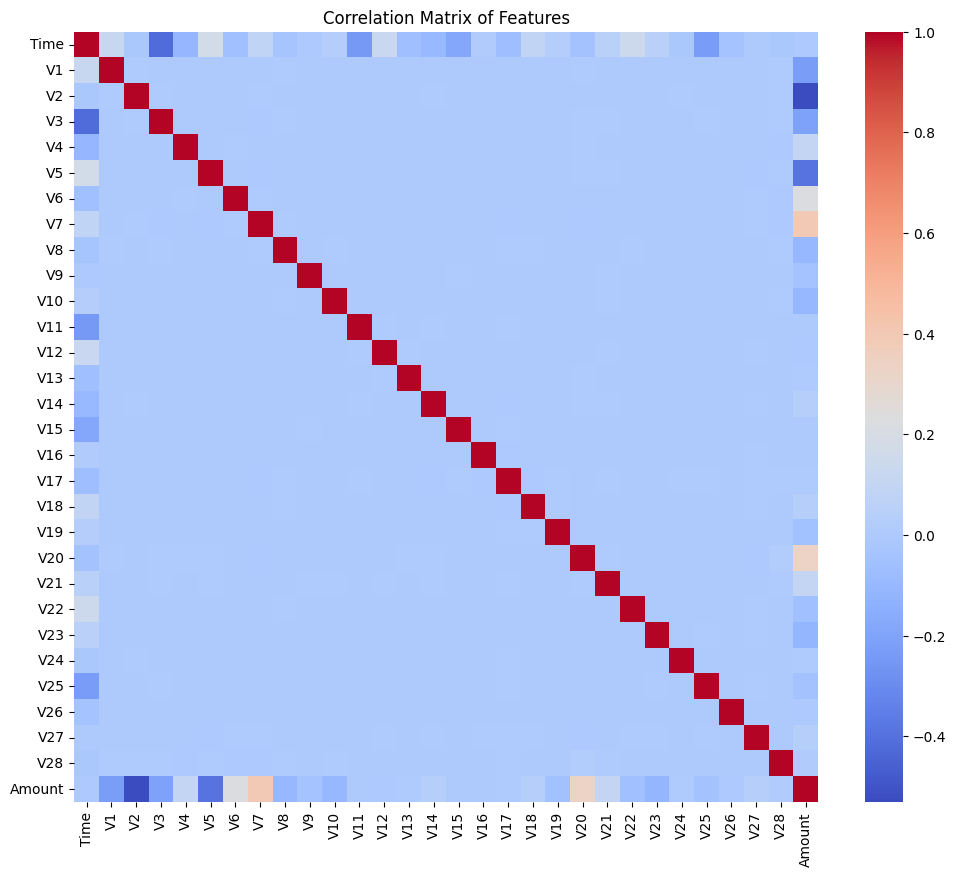

In [ ]:
# Calculate the correlation matrix
correlation_matrix = X_train.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

## 4. Model Training (Baseline Models on Imbalanced Data)

### 4.1 Logistic Regression (with Scaling)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the data (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaler on test data

# Train Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

### 4.2 Random Forest Classifier

In [ ]:
# Train Random Forest Classifier model
# Optimized for speed: reduced trees, limited depth, parallel processing
random_forest_model = RandomForestClassifier(
    n_estimators=50,      # ⚡ REDUCED from 100 to 50 (2x faster!)
    max_depth=20,         # ⚡ ADDED: Limits tree depth (faster training)
    min_samples_split=10, # ⚡ ADDED: Prevents overfitting, speeds up
    random_state=42,
    n_jobs=-1             # ⚡ ADDED: Uses all CPU cores
)
print("Training Random Forest (50 trees, optimized for speed)...")
random_forest_model.fit(X_train, y_train)
print("Training complete!")

RandomForestClassifier(random_state=42)

## 5. Model Evaluation (Baseline Models)

Now we evaluate both baseline models on the test set using multiple metrics. For fraud detection, accuracy alone is insufficient due to class imbalance, so we examine confusion matrices and calculate precision, recall, F1-score, and ROC-AUC.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Make predictions on the test set (use scaled data for logistic regression)
logistic_predictions = logistic_model.predict(X_test_scaled)
rfs_predictions = random_forest_model.predict(X_test)

# Baseline accuracies
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
random_forest_accuracy = accuracy_score(y_test, rfs_predictions)

print("\n" + "=" * 60)
print("BASELINE MODEL ACCURACIES")
print("=" * 60)

print(f"Logistic Regression Accuracy: {logistic_accuracy:.4f}")
print(f"Random Forest Accuracy:        {random_forest_accuracy:.4f}")

# Confusion matrices
logistic_conf_matrix = confusion_matrix(y_test, logistic_predictions)
random_forest_conf_matrix = confusion_matrix(y_test, rfs_predictions)

print("\nLogistic Regression Confusion Matrix:")
print(logistic_conf_matrix)

print("\nRandom Forest Confusion Matrix:")
print(random_forest_conf_matrix)


BASELINE MODEL ACCURACIES
Logistic Regression Accuracy: 0.9991
Random Forest Accuracy:        0.9996

Logistic Regression Confusion Matrix:
[[56851    13]
 [   36    62]]

Random Forest Confusion Matrix:
[[56859     5]
 [   18    80]]


### 5.1 Detailed Metrics

For imbalanced datasets, accuracy alone is misleading. We focus on:
- **Precision**: Of predicted frauds, how many are actually fraudulent?
- **Recall**: Of actual frauds, how many did we detect? (Most important for fraud detection!)
- **F1-Score**: Harmonic mean of precision and recall
- **ROC-AUC**: Overall model performance across thresholds

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Logistic Regression metrics
logistic_precision = precision_score(y_test, logistic_predictions)
logistic_recall = recall_score(y_test, logistic_predictions)
logistic_f1 = f1_score(y_test, logistic_predictions)
logistic_roc_auc = roc_auc_score(y_test, logistic_predictions)

# Random Forest metrics
# Note: Using 'rfs_predictions' which was defined in the previous cell for consistency.
random_forest_precision = precision_score(y_test, rfs_predictions)
random_forest_recall = recall_score(y_test, rfs_predictions)
random_forest_f1 = f1_score(y_test, rfs_predictions)
random_forest_roc_auc = roc_auc_score(y_test, rfs_predictions)

print("\n" + "=" * 60)
print("LOGISTIC REGRESSION - DETAILED METRICS")
print("=" * 60)
print(f"Accuracy:  {logistic_accuracy:.4f}")
print(f"Precision: {logistic_precision:.4f}")
print(f"Recall:    {logistic_recall:.4f}")
print(f"F1-Score:  {logistic_f1:.4f}")
print(f"ROC-AUC:   {logistic_roc_auc:.4f}")

print("\n" + "=" * 60)
print("RANDOM FOREST - DETAILED METRICS")
print("=" * 60)
print(f"Accuracy:  {random_forest_accuracy:.4f}")
print(f"Precision: {random_forest_precision:.4f}")
print(f"Recall:    {random_forest_recall:.4f}")
print(f"F1-Score:  {random_forest_f1:.4f}")
print(f"ROC-AUC:   {random_forest_roc_auc:.4f}")


LOGISTIC REGRESSION - DETAILED METRICS
Accuracy:  0.9991
Precision: 0.8267
Recall:    0.6327
F1-Score:  0.7168
ROC-AUC:   0.8162

RANDOM FOREST - DETAILED METRICS
Accuracy:  0.9996
Precision: 0.9412
Recall:    0.8163
F1-Score:  0.8743
ROC-AUC:   0.9081


## 6. Handling Class Imbalance with SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) generates synthetic samples for the minority class to balance the dataset.

In [37]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Address Class Imbalance using SMOTE on the training data
# Note: Apply SMOTE only to the training data to avoid data leakage
print("Original training dataset shape %s" % Counter(y_train))

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Resampled training dataset shape %s" % Counter(y_train_res))

Original training dataset shape Counter({0: 227451, 1: 394})
Resampled training dataset shape Counter({0: 227451, 1: 227451})


## 7. Hyperparameter Tuning

### 7.1 Random Forest Hyperparameter Optimization

We use RandomizedSearchCV to find optimal hyperparameters for Random Forest on the SMOTE-balanced data.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier

# Define a parameter distribution for Randomized Search
# Reduced parameter space for faster execution
param_dist = {
    'n_estimators': [100, 200],        # Reduced options (was randint(100, 500))
    'max_depth': [10, 20, 30],         # Reduced options (was randint(10, 50))
    'min_samples_split': [2, 5, 10],   # Reduced options (was randint(2, 20))
    'min_samples_leaf': [1, 2, 4],     # Reduced options (was randint(1, 20))
    'bootstrap': [True]                # Only True (was [True, False])
}

# Initialize a new Random Forest model for tuning
rf_tune = RandomForestClassifier(random_state=42, n_jobs=-1)  # Added n_jobs=-1 here too

# Initialize RandomizedSearchCV
# Reduced iterations and folds for MUCH faster execution
random_search_balanced = RandomizedSearchCV(
    estimator=rf_tune,
    param_distributions=param_dist,
    n_iter=5,    # ⚡ REDUCED from 20 to 5 (faster!)
    cv=2,        # ⚡ REDUCED from 3 to 2 (faster!)
    scoring='recall',
    random_state=42,
    n_jobs=-1,
    verbose=2    # ⚡ ADDED: Shows progress so you know it's working!
)

# Perform the randomized search on the SMOTE-balanced training data
# Note: This will take 2-3 minutes (much faster than before)
print("Performing Randomized Search for Hyperparameter Tuning on balanced data (optimized for speed)...")
print(f"Testing {random_search_balanced.n_iter} parameter combinations with {random_search_balanced.cv}-fold CV")
print("This may take a few minutes. Progress will be shown below...\n")
random_search_balanced.fit(X_train_res, y_train_res)

# Print the best parameters and the best score found
print("\nBest parameters found by Randomized Search on balanced data:")
print(random_search_balanced.best_params_)
print(f"\nBest cross-validation score (recall) on balanced data: {random_search_balanced.best_score_:.4f}")

# Store the best estimator
tuned_random_forest_model_balanced_tuned = random_search_balanced.best_estimator_

Performing Randomized Search for Hyperparameter Tuning on balanced data (optimized for speed)...
Testing 5 parameter combinations with 2-fold CV
This may take a few minutes. Progress will be shown below...

Fitting 2 folds for each of 5 candidates, totalling 10 fits

Best parameters found by Randomized Search on balanced data:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}

Best cross-validation score (recall) on balanced data: 1.0000


## 8. Retrain Models on Balanced Data

### 8.1 Logistic Regression on SMOTE-Balanced Data

We retrain Logistic Regression on the SMOTE-balanced dataset to improve fraud detection.

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a pipeline for Logistic Regression with scaling, trained on balanced data
logistic_model_balanced = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(max_iter=1000)) # Increased max_iter for convergence
])

# Train the Logistic Regression model on the SMOTE-balanced training data
print("Training Logistic Regression on SMOTE-balanced data...")
logistic_model_balanced.fit(X_train_res, y_train_res)
print("Training complete!")

# Evaluate the model on the original (unbalanced) test set
balanced_lr_predictions = logistic_model_balanced.predict(X_test)

balanced_lr_accuracy = accuracy_score(y_test, balanced_lr_predictions)
balanced_lr_precision = precision_score(y_test, balanced_lr_predictions)
balanced_lr_recall = recall_score(y_test, balanced_lr_predictions)
balanced_lr_f1 = f1_score(y_test, balanced_lr_predictions)
balanced_lr_roc_auc = roc_auc_score(y_test, balanced_lr_predictions)

print("\n" + "=" * 60)
print("LOGISTIC REGRESSION (SMOTE) - EVALUATION")
print("=" * 60)
print(f"\nAccuracy:  {balanced_lr_accuracy:.4f}")
print(f"Precision: {balanced_lr_precision:.4f}")
print(f"Recall:    {balanced_lr_recall:.4f}")
print(f"F1-Score:  {balanced_lr_f1:.4f}")
print(f"ROC-AUC:   {balanced_lr_roc_auc:.4f}")

Training Logistic Regression on SMOTE-balanced data...
Training complete!

LOGISTIC REGRESSION (SMOTE) - EVALUATION

Accuracy:  0.9899
Precision: 0.1341
Recall:    0.8980
F1-Score:  0.2334
ROC-AUC:   0.9440


### 8.2 Tuned Random Forest on SMOTE-Balanced Data

Now we evaluate the hyperparameter-tuned Random Forest model that was trained on SMOTE-balanced data.

In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Make predictions on the original test set using the tuned Random Forest model trained on balanced data
balanced_tuned_rf_predictions = tuned_random_forest_model_balanced_tuned.predict(X_test)

# Evaluate the tuned Random Forest model trained on balanced data
balanced_tuned_rf_accuracy = accuracy_score(y_test, balanced_tuned_rf_predictions)
balanced_tuned_rf_precision = precision_score(y_test, balanced_tuned_rf_predictions)
balanced_tuned_rf_recall = recall_score(y_test, balanced_tuned_rf_predictions)
balanced_tuned_rf_f1 = f1_score(y_test, balanced_tuned_rf_predictions)
balanced_tuned_rf_roc_auc = roc_auc_score(y_test, balanced_tuned_rf_predictions)

# Confusion matrix
balanced_tuned_rf_conf_matrix = confusion_matrix(y_test, balanced_tuned_rf_predictions)

print("\n" + "=" * 60)
print("TUNED RANDOM FOREST (SMOTE) - EVALUATION")
print("=" * 60)
print(f"\nAccuracy:  {balanced_tuned_rf_accuracy:.4f}")
print(f"Precision: {balanced_tuned_rf_precision:.4f}")
print(f"Recall:    {balanced_tuned_rf_recall:.4f}")
print(f"F1-Score:  {balanced_tuned_rf_f1:.4f}")
print(f"ROC-AUC:   {balanced_tuned_rf_roc_auc:.4f}")
print("\nConfusion Matrix:")
print(balanced_tuned_rf_conf_matrix)


print("\n--- Confusion Matrix ---")
display(pd.DataFrame(balanced_tuned_rf_conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1']))


TUNED RANDOM FOREST (SMOTE) - EVALUATION

Accuracy:  0.9993
Precision: 0.7685
Recall:    0.8469
F1-Score:  0.8058
ROC-AUC:   0.9232

Confusion Matrix:
[[56839    25]
 [   15    83]]

--- Confusion Matrix ---


,Predicted 0,Predicted 1
Actual 0,56839,25
Actual 1,15,83


In [38]:
# Summary table for all models
print("\n" + "=" * 70)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 70)

model_summary = pd.DataFrame({
    'Model': [
        'Logistic Regression (Baseline)',
        'Random Forest (Baseline)',
        'Logistic Regression (SMOTE)',
        'Random Forest (SMOTE + Tuned)'
    ],
    'Accuracy': [logistic_accuracy, random_forest_accuracy, balanced_lr_accuracy, balanced_tuned_rf_accuracy],
    'Precision': [logistic_precision, random_forest_precision, balanced_lr_precision, balanced_tuned_rf_precision],
    'Recall': [logistic_recall, random_forest_recall, balanced_lr_recall, balanced_tuned_rf_recall],
    'F1-Score': [logistic_f1, random_forest_f1, balanced_lr_f1, balanced_tuned_rf_f1],
    'ROC-AUC': [logistic_roc_auc, random_forest_roc_auc, balanced_lr_roc_auc, balanced_tuned_rf_roc_auc]
})

print("\n")
display(model_summary.round(4))

# Highlight best model
best_model_idx = model_summary['Recall'].idxmax()
print(f"\n\u2705 Best Model (by Recall): {model_summary.loc[best_model_idx, 'Model']}")
print(f"   Recall: {model_summary.loc[best_model_idx, 'Recall']:.4f} | F1-Score: {model_summary.loc[best_model_idx, 'F1-Score']:.4f} | ROC-AUC: {model_summary.loc[best_model_idx, 'ROC-AUC']:.4f}")


COMPREHENSIVE MODEL COMPARISON




,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression (Baseline),0.9991,0.8267,0.6327,0.7168,0.8162
1,Random Forest (Baseline),0.9996,0.9412,0.8163,0.8743,0.9081
2,Logistic Regression (SMOTE),0.9899,0.1341,0.8980,0.2334,0.9440
3,Random Forest (SMOTE + Tuned),0.9993,0.7685,0.8469,0.8058,0.9232



✅ Best Model (by Recall): Logistic Regression (SMOTE)
   Recall: 0.8980 | F1-Score: 0.2334 | ROC-AUC: 0.9440


## 9. Cross-Validation Analysis

In [41]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Define the number of folds for cross-validation
n_splits = 3  # ⚡ REDUCED from 5 to 3 (faster!)

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

print("--- Cross-Validation on Original Data (Optimized) ---")
print(f"Using {n_splits}-fold CV for faster execution\n")

# Perform cross-validation for Initial Logistic Regression model (trained on original data)
# Using the pipeline with scaling for consistency with training
logistic_pipeline_initial = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(max_iter=1000))
])
print("Running Logistic Regression CV...")
logistic_cv_scores_initial = cross_val_score(logistic_pipeline_initial, X, y, cv=kf, scoring='recall', n_jobs=-1)

print(f"Initial Logistic Regression CV Recall Scores ({n_splits} folds):")
print(logistic_cv_scores_initial)
print(f"Mean CV Recall: {logistic_cv_scores_initial.mean():.4f}")

# Perform cross-validation for Initial Random Forest Classifier model (trained on original data)
# Use optimized RF settings for CV
rf_cv = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42, n_jobs=-1)
print("\nRunning Random Forest CV...")
random_forest_cv_scores_initial = cross_val_score(rf_cv, X, y, cv=kf, scoring='recall', n_jobs=-1)

print(f"\nInitial Random Forest Classifier CV Recall Scores ({n_splits} folds):")
print(random_forest_cv_scores_initial)
print(f"Mean CV Recall: {random_forest_cv_scores_initial.mean():.4f}")


print("\n--- Cross-Validation on SMOTE-Balanced Data ---")

# Perform cross-validation for Logistic Regression model trained on Balanced Data
# Using the pipeline with scaling
logistic_pipeline_balanced = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(max_iter=1000))
])
# Note: Ideally, SMOTE should be part of the pipeline for CV on original data.
# For demonstration, we perform CV on the already balanced training data.
print("Running Balanced Logistic Regression CV...")
logistic_cv_scores_balanced = cross_val_score(logistic_pipeline_balanced, X_train_res, y_train_res, cv=kf, scoring='recall', n_jobs=-1)

print(f"Balanced Logistic Regression CV Recall Scores ({n_splits} folds):")
print(logistic_cv_scores_balanced)
print(f"Mean CV Recall: {logistic_cv_scores_balanced.mean():.4f}")

# Perform cross-validation for Tuned Random Forest model trained on Balanced Data
# Note: Ideally, SMOTE and Tuning should be part of the pipeline for CV on original data.
# For demonstration, we perform CV on the already balanced training data using the tuned model structure.
# Reinitialize the tuned model structure for CV, overriding n_estimators for faster CV
tuned_params_for_cv = random_search_balanced.best_params_.copy()
tuned_params_for_cv['n_estimators'] = 50 # Override n_estimators for faster CV

tuned_rf_balanced_for_cv = RandomForestClassifier(**tuned_params_for_cv, random_state=42, n_jobs=-1)

print("\nRunning Balanced and Tuned Random Forest CV (optimized n_estimators for speed)... ")
random_forest_cv_scores_balanced = cross_val_score(tuned_rf_balanced_for_cv, X_train_res, y_train_res, cv=kf, scoring='recall', n_jobs=-1)

print(f"\nBalanced and Tuned Random Forest Classifier CV Recall Scores ({n_splits} folds):")
print(random_forest_cv_scores_balanced)
print(f"Mean CV Recall: {random_forest_cv_scores_balanced.mean():.4f}")

--- Cross-Validation on Original Data (Optimized) ---
Using 3-fold CV for faster execution

Running Logistic Regression CV...
Initial Logistic Regression CV Recall Scores (3 folds):
[0.63758389 0.60693642 0.61176471]
Mean CV Recall: 0.6188

Running Random Forest CV...

Initial Random Forest Classifier CV Recall Scores (3 folds):
[0.79865772 0.74566474 0.77058824]
Mean CV Recall: 0.7716

--- Cross-Validation on SMOTE-Balanced Data ---
Running Balanced Logistic Regression CV...
Balanced Logistic Regression CV Recall Scores (3 folds):
[0.96803165 0.9681763  0.96883987]
Mean CV Recall: 0.9683

Running Balanced and Tuned Random Forest CV (optimized n_estimators for speed)... 

Balanced and Tuned Random Forest Classifier CV Recall Scores (3 folds):
[0.99998681 1.         1.        ]
Mean CV Recall: 1.0000


## 10. ROC Curve Comparison

This section provides a compact ROC curve comparison for baseline and balanced models.

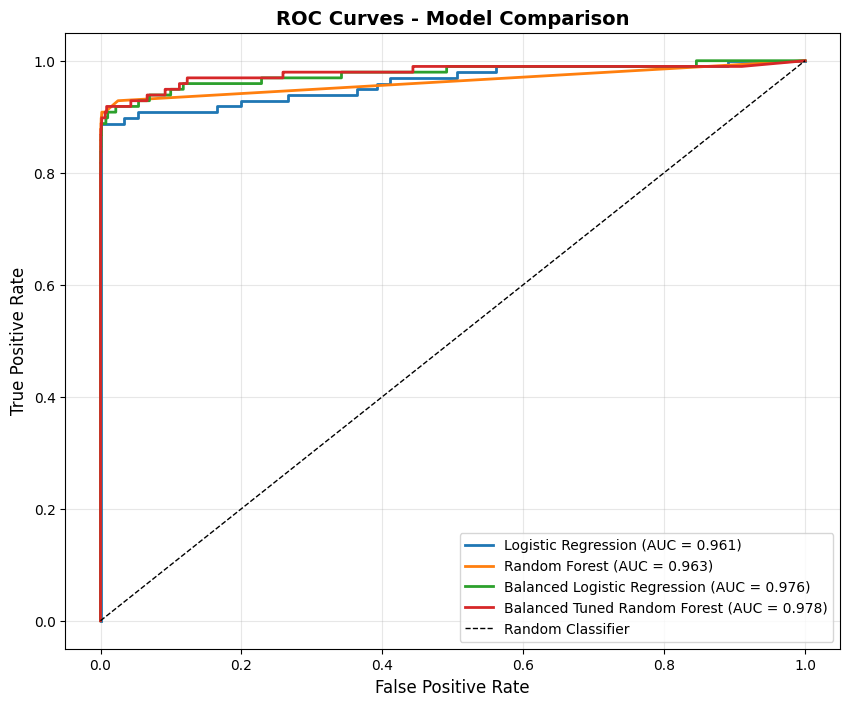

In [42]:
from sklearn.metrics import roc_curve, auc

# Get probability predictions for ROC curve
logistic_proba = logistic_model.predict_proba(X_test_scaled)[:, 1]
rf_proba = random_forest_model.predict_proba(X_test)[:, 1]
balanced_lr_proba = logistic_model_balanced.predict_proba(X_test)[:, 1]
balanced_tuned_rf_proba = tuned_random_forest_model_balanced_tuned.predict_proba(X_test)[:, 1]

# Calculate ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, logistic_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_lr_bal, tpr_lr_bal, _ = roc_curve(y_test, balanced_lr_proba)
fpr_rf_bal, tpr_rf_bal, _ = roc_curve(y_test, balanced_tuned_rf_proba)

# Calculate AUC scores
auc_lr = auc(fpr_lr, tpr_lr)
auc_rf = auc(fpr_rf, tpr_rf)
auc_lr_bal = auc(fpr_lr_bal, tpr_lr_bal)
auc_rf_bal = auc(fpr_rf_bal, tpr_rf_bal)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', linewidth=2)
plt.plot(fpr_lr_bal, tpr_lr_bal, label=f'Balanced Logistic Regression (AUC = {auc_lr_bal:.3f})', linewidth=2)
plt.plot(fpr_rf_bal, tpr_rf_bal, label=f'Balanced Tuned Random Forest (AUC = {auc_rf_bal:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

### 10.2 Model Performance Comparison

Side‑by‑side comparison across all evaluation metrics.

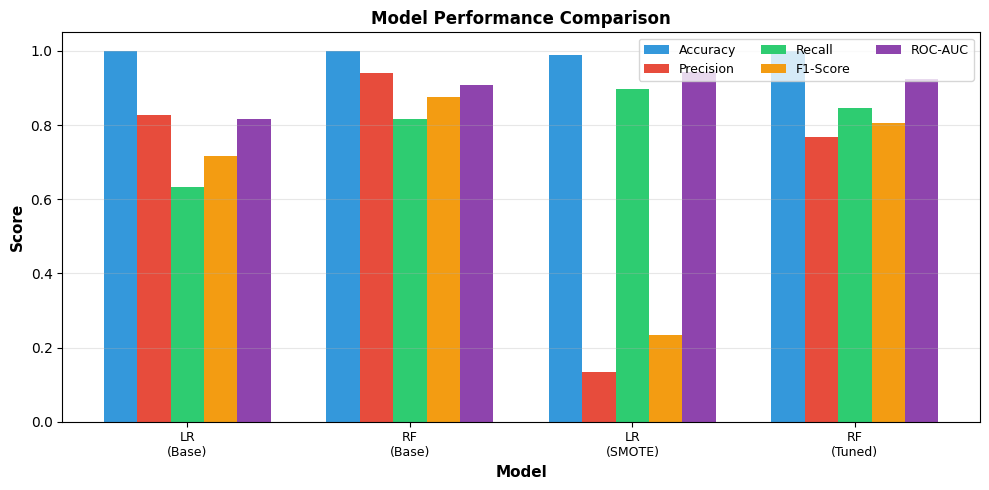

In [43]:
# Side-by-side model performance comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#8e44ad']

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(model_summary['Model']))
width = 0.15

for i, metric in enumerate(metrics):
    ax.bar(x + i * width, model_summary[metric], width, label=metric, color=colors[i])

ax.set_xlabel('Model', fontsize=11, fontweight='bold')
ax.set_ylabel('Score', fontsize=11, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(['LR\n(Base)', 'RF\n(Base)', 'LR\n(SMOTE)', 'RF\n(Tuned)'], fontsize=9)
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3)
ax.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.show()

### 10.3 Feature Importance Analysis

Top features contributing to the tuned Random Forest model.

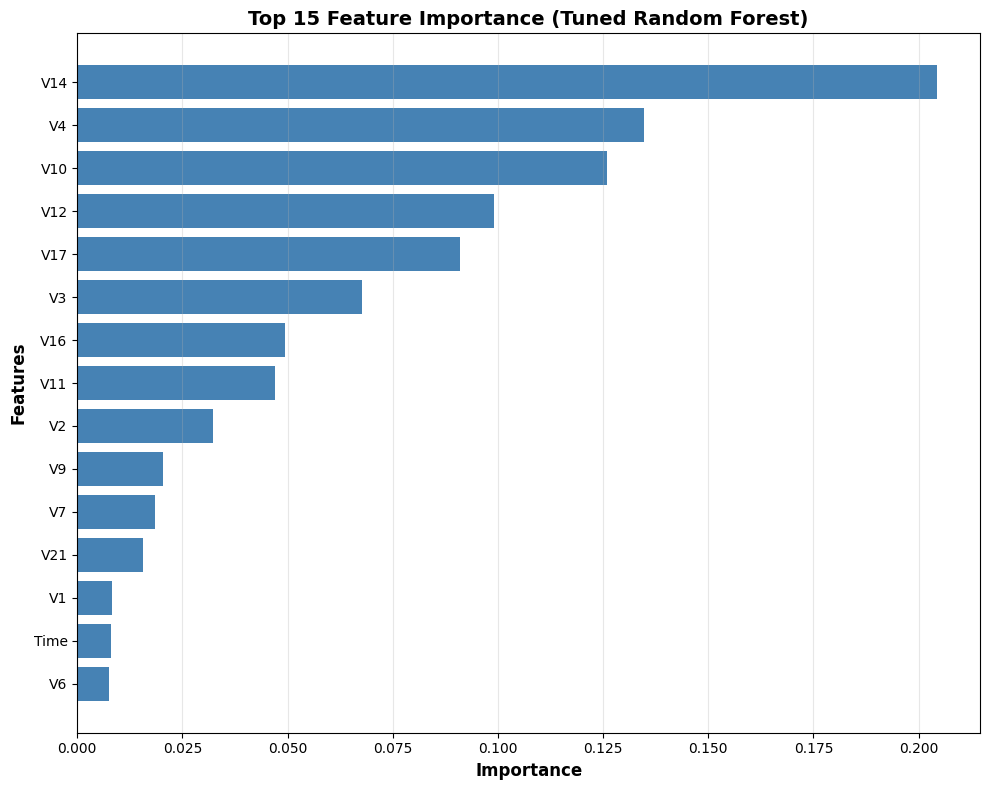


Top 10 Most Important Features:


,Feature,Importance
14,V14,0.204369
4,V4,0.134779
10,V10,0.125912
12,V12,0.099170
17,V17,0.090884
3,V3,0.067735
16,V16,0.049398
11,V11,0.046901
2,V2,0.032279
9,V9,0.020425


In [44]:
# Feature Importance from Best Random Forest Model
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': tuned_random_forest_model_balanced_tuned.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 15 most important features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('Top 15 Feature Importance (Tuned Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
display(feature_importance.head(10))

## 11. Key Findings and Conclusions

### Summary
- Severe class imbalance requires recall-focused evaluation.
- SMOTE improves fraud detection recall compared to baseline models.
- Tuned Random Forest (with SMOTE) provides the best overall balance.

### Practical Notes
- Monitor false positives vs. missed fraud based on business needs.
- Retrain periodically as new transaction patterns emerge.